# Imports
---

In [12]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import spacy
import torch
from optuna.exceptions import TrialPruned
from optuna.pruners import MedianPruner
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from ensemble_model import EnsembleModel
from extract_features import (
    extract_linguistic_features,
    extract_sbert_features,
    extract_semantic_features,
)
from prepare_data import extract_claim_evidence_pairs, load_jsonl
from tune_model import ScifactDataset, train_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Util
---

In [2]:
np.random.seed(42)

device_str = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = torch.device(device_str)

evidence_decode = {0: "NOT EVIDENCE", 1: "EVIDENCE"}
evidence_encode = {"NOT EVIDENCE": 0, "EVIDENCE": 1}

label_decode = {0: "SUPPORT", 1: "CONTRADICT", 2: "NO_RELATION"}
label_encode = {"SUPPORT": 0, "CONTRADICT": 1, "NO_RELATION": 2}

drop_features = ["claim_id", "doc_id", "label", "is_evidence"]

# Data Processing
---

Load the scifact corups and training and development fact sets.

In [3]:
SCIFACT_DIR = os.getenv("SCIFACT_DATA")
CORPUS_PATH = os.path.join(SCIFACT_DIR, "corpus.jsonl")
CLAIMS_TRAIN_PATH = os.path.join(SCIFACT_DIR, "claims_train.jsonl")
CLAIMS_DEV_PATH = os.path.join(SCIFACT_DIR, "claims_dev.jsonl")

corpus = load_jsonl(CORPUS_PATH)
claims_train = load_jsonl(CLAIMS_TRAIN_PATH)
claims_dev = load_jsonl(CLAIMS_DEV_PATH)

corpus_dict = {doc["doc_id"]: doc for doc in corpus}

Extract claim-evidence pairs from the datasets

In [4]:
train_df = extract_claim_evidence_pairs(claims_train, corpus_dict)
dev_df = extract_claim_evidence_pairs(claims_dev, corpus_dict)

print(f"Training set: {len(train_df)} samples")
print(f"Development set: {len(dev_df)} samples")
print("\nLabel distribution in training set:")
display(train_df["label"].value_counts().to_frame())
print("\nEvidence vs Non-evidence in training set:")
display(train_df["is_evidence"].map(evidence_decode).value_counts().to_frame())

Training set: 1914 samples
Development set: 676 samples

Label distribution in training set:


,count
label,
NO_RELATION,957
SUPPORT,616
CONTRADICT,341



Evidence vs Non-evidence in training set:


,count
is_evidence,
EVIDENCE,957
NOT EVIDENCE,957


# Feature Extraction
---

Extract features from dataset

In [5]:
sbert_model = SentenceTransformer(
    "all-MiniLM-L6-v2",
    model_kwargs={"torch_dtype": "float16"},
    device=device_str,
)
spacy_model = spacy.load("en_core_web_lg")


def extract_features(df):
    features_list = []
    for _, row in df.iterrows():
        claim = row["claim"]
        evidence = row["evidence"]

        # Extract features
        linguistic_features = extract_linguistic_features(spacy_model, claim, evidence)
        semantic_features = extract_semantic_features(spacy_model, claim, evidence)
        sbert_features = extract_sbert_features(sbert_model, claim, evidence)

        # Combine all features
        combined_features = {
            **linguistic_features,
            **semantic_features,
            **sbert_features,
        }
        combined_features["claim_id"] = row["claim_id"]
        combined_features["doc_id"] = row["doc_id"]
        combined_features["label"] = row["label"]
        combined_features["is_evidence"] = row["is_evidence"]

        features_list.append(combined_features)
    return pd.DataFrame(features_list)


train_features = extract_features(train_df)
dev_features = extract_features(dev_df)

Reduce SBERT embeddings into features using PCA

In [6]:
def reduce_sbert_dimensions(features_df, n_components=50):
    """Reduce SBERT embedding dimensions using PCA."""
    # Combine claim and evidence embeddings
    sbert_embeddings = np.hstack(
        [
            np.vstack(features_df["sbert_claim_embedding"]),
            np.vstack(features_df["sbert_evidence_embedding"]),
        ],
    )

    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    reduced_embeddings = pca.fit_transform(sbert_embeddings)

    # Create new feature columns
    reduced_columns = [f"sbert_pca_dim_{i}" for i in range(n_components)]
    reduced_df = pd.DataFrame(reduced_embeddings, columns=reduced_columns)

    # Drop original embeddings and add reduced features
    features_df = features_df.drop(
        ["sbert_claim_embedding", "sbert_evidence_embedding"],
        axis=1,
    )
    return pd.concat([features_df, reduced_df], axis=1)


train_features = reduce_sbert_dimensions(train_features)
dev_features = reduce_sbert_dimensions(dev_features)

In [7]:
print(
    f"Extracted {len(train_features.columns) - 4} features for training and development sets"
)
print(f"Training set shape: {train_features.shape}")
print(f"Development set shape: {dev_features.shape}")

Extracted 78 features for training and development sets
Training set shape: (1914, 82)
Development set shape: (676, 82)


Extract features for binary and relational classification

In [8]:
binary_train_X = train_features.drop(drop_features, axis=1)
binary_train_y = train_features["is_evidence"]

binary_dev_X = dev_features.drop(drop_features, axis=1)
binary_dev_y = dev_features["is_evidence"]

# Relation classification data (only for actual evidence)
relation_train = train_features[train_features["is_evidence"] == 1].copy()
relation_train_X = relation_train.drop(drop_features, axis=1)
relation_train_y = relation_train["label"].map(label_encode)

relation_dev = dev_features[dev_features["is_evidence"] == 1].copy()
relation_dev_X = relation_dev.drop(drop_features, axis=1)
relation_dev_y = relation_dev["label"].map(label_encode)

# Model Tuning
---

### SCIBERT

Train scibert on dataset

In [9]:
# Initialize tokenizer and model
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Create datasets and dataloaders
train_dataset = ScifactDataset(train_df, tokenizer)
dev_dataset = ScifactDataset(dev_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8)

trained_model = train_model(device, model, train_dataloader, dev_dataloader, epochs=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [02:14<00:00,  1.78it/s, loss=0.399]


Epoch 1 - Average training loss: 0.9130
Evaluating...
Accuracy: 0.5828
Weighted F1 Score: 0.5601

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       216
           1       0.15      0.09      0.11       122
           2       0.69      0.79      0.74       338

    accuracy                           0.58       676
   macro avg       0.46      0.47      0.46       676
weighted avg       0.54      0.58      0.56       676



Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [02:17<00:00,  1.74it/s, loss=1.28]


Epoch 2 - Average training loss: 0.7644
Evaluating...
Accuracy: 0.6257
Weighted F1 Score: 0.6377

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       216
           1       0.34      0.43      0.38       122
           2       0.84      0.70      0.76       338

    accuracy                           0.63       676
   macro avg       0.58      0.58      0.58       676
weighted avg       0.66      0.63      0.64       676



Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [02:16<00:00,  1.76it/s, loss=0.0361]


Epoch 3 - Average training loss: 0.5945
Evaluating...
Accuracy: 0.5947
Weighted F1 Score: 0.6071

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55       216
           1       0.32      0.38      0.35       122
           2       0.83      0.66      0.73       338

    accuracy                           0.59       676
   macro avg       0.55      0.55      0.55       676
weighted avg       0.63      0.59      0.61       676



Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [02:21<00:00,  1.70it/s, loss=0.7]


Epoch 4 - Average training loss: 0.4670
Evaluating...
Accuracy: 0.5680
Weighted F1 Score: 0.5904

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.60      0.54       216
           1       0.31      0.50      0.38       122
           2       0.88      0.57      0.70       338

    accuracy                           0.57       676
   macro avg       0.56      0.56      0.54       676
weighted avg       0.66      0.57      0.59       676



### Binary Classifier

Tune binary classifier hyper-parameter using optuna

In [10]:
# Define the objective function for Optuna
def binary_objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Define the pipeline
    binary_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "classifier",
                RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    max_features=max_features,
                    random_state=42,
                    class_weight="balanced",
                ),
            ),
        ],
    )

    # Perform stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(binary_train_X, binary_train_y),
    ):
        binary_pipeline.fit(
            binary_train_X.iloc[train_idx],
            binary_train_y.iloc[train_idx],
        )
        predictions = binary_pipeline.predict(binary_train_X.iloc[val_idx])

        score = f1_score(binary_train_y.iloc[val_idx], predictions)
        scores.append(score)

        trial.report(score, step=fold_idx)
        if trial.should_prune():
            raise TrialPruned

    # Return the mean F1 score
    return np.mean(scores)


# Run Optuna optimization
binary_study = optuna.create_study(direction="maximize", pruner=MedianPruner())
binary_study.optimize(binary_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

best_binary_params = binary_study.best_params
print("Best hyperparameters for binary classifier:", best_binary_params)

[I 2025-05-06 16:27:39,736] A new study created in memory with name: no-name-332d7e65-5cd3-4528-b9da-70414e60c46f


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-06 16:27:42,694] Trial 7 finished with value: 0.6488065266951397 and parameters: {'n_estimators': 125, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 7 with value: 0.6488065266951397.
[I 2025-05-06 16:27:43,601] Trial 5 finished with value: 0.6694096204638372 and parameters: {'n_estimators': 150, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6694096204638372.
[I 2025-05-06 16:27:44,152] Trial 3 finished with value: 0.667312311723188 and parameters: {'n_estimators': 173, 'max_depth': 42, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6694096204638372.
[I 2025-05-06 16:27:47,300] Trial 1 finished with value: 0.6647927074399019 and parameters: {'n_estimators': 354, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 5 with value: 0.669409620463

Create binary classifier pipeline with best parameters

In [13]:
# Initialize the binary classifier with the best parameters
binary_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "classifier",
            RandomForestClassifier(
                n_estimators=best_binary_params["n_estimators"],
                max_depth=best_binary_params["max_depth"],
                min_samples_split=best_binary_params["min_samples_split"],
                min_samples_leaf=best_binary_params["min_samples_leaf"],
                max_features=best_binary_params["max_features"],
                random_state=42,
                class_weight="balanced",
            ),
        ),
    ],
)

# Train the binary classifier with the best parameters
binary_pipeline.fit(binary_train_X, binary_train_y)
binary_predictions = binary_pipeline.predict(binary_dev_X)

# Evaluate the binary classifier
binary_accuracy = accuracy_score(binary_dev_y, binary_predictions)
binary_f1 = f1_score(binary_dev_y, binary_predictions)

print(f"Binary Classification - Accuracy: {binary_accuracy:.4f}, F1: {binary_f1:.4f}")
print("\nClassification Report (Binary):")
print(
    classification_report(
        binary_dev_y, binary_predictions, target_names=["EVIDENCE", "NON-EVIDENCE"]
    )
)

Binary Classification - Accuracy: 0.6672, F1: 0.6744

Classification Report (Binary):
              precision    recall  f1-score   support

    EVIDENCE       0.67      0.64      0.66       338
NON-EVIDENCE       0.66      0.69      0.67       338

    accuracy                           0.67       676
   macro avg       0.67      0.67      0.67       676
weighted avg       0.67      0.67      0.67       676



### Relation Classifier

Tune relation classifier hyper-parameter using optuna

In [14]:
# Define the objective function for Optuna
def relation_objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 0.01, 100, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    # Define the pipeline
    relation_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "classifier",
                SVC(
                    C=C,
                    kernel=kernel,
                    gamma=gamma,
                    probability=True,
                    random_state=42,
                    class_weight="balanced",
                ),
            ),
        ],
    )

    # Perform stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(relation_train_X, relation_train_y),
    ):
        relation_pipeline.fit(
            relation_train_X.iloc[train_idx],
            relation_train_y.iloc[train_idx],
        )
        predictions = relation_pipeline.predict(relation_train_X.iloc[val_idx])

        score = f1_score(relation_train_y.iloc[val_idx], predictions)
        scores.append(score)

        trial.report(score, step=fold_idx)
        if trial.should_prune():
            raise TrialPruned

    # Return the mean F1 score
    return np.mean(scores)


# Run Optuna optimization
relation_study = optuna.create_study(direction="maximize", pruner=MedianPruner())
relation_study.optimize(
    relation_objective,
    n_trials=100,
    n_jobs=-1,
    show_progress_bar=True,
)

best_relation_params = relation_study.best_params
print("Best hyperparameters for relation classifier:", best_relation_params)

[I 2025-05-06 16:36:29,374] A new study created in memory with name: no-name-17024afa-45ba-47e6-9113-1dea8cf1ee7e


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-06 16:36:29,628] Trial 1 finished with value: 0.38190234653437116 and parameters: {'C': 0.04215787416519296, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 1 with value: 0.38190234653437116.
[I 2025-05-06 16:36:29,644] Trial 2 finished with value: 0.3255581692493181 and parameters: {'C': 0.2831619098499066, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 1 with value: 0.38190234653437116.
[I 2025-05-06 16:36:29,653] Trial 7 finished with value: 0.45307574900104614 and parameters: {'C': 17.629245660149827, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 7 with value: 0.45307574900104614.
[I 2025-05-06 16:36:29,667] Trial 5 finished with value: 0.4982055490064643 and parameters: {'C': 5.00393019232166, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 5 with value: 0.4982055490064643.
[I 2025-05-06 16:36:29,704] Trial 0 finished with value: 0.4966346365429713 and parameters: {'C': 0.19377940706164415, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 5 with value:

Create relation classifier pipeline with best parameters

In [15]:
# Initialize the relation classifier with the best parameters
relation_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "classifier",
            SVC(
                C=best_relation_params["C"],
                kernel=best_relation_params["kernel"],
                gamma=best_relation_params["gamma"],
                probability=True,
                random_state=42,
                class_weight="balanced",
            ),
        ),
    ],
)

# Train the relation classifier with the best parameters
relation_pipeline.fit(relation_train_X, relation_train_y)
relation_predictions = relation_pipeline.predict(relation_dev_X)

# Evaluate the relation classifier
relation_accuracy = accuracy_score(relation_dev_y, relation_predictions)
relation_f1 = f1_score(relation_dev_y, relation_predictions)

print(
    f"Relation Classification - Accuracy: {relation_accuracy:.4f}, F1: {relation_f1:.4f}"
)
print("\nClassification Report (Relation):")
print(
    classification_report(
        relation_dev_y, relation_predictions, target_names=["SUPPORT", "CONTRADICT"]
    )
)

Relation Classification - Accuracy: 0.5355, F1: 0.4249

Classification Report (Relation):
              precision    recall  f1-score   support

     SUPPORT       0.66      0.57      0.61       216
  CONTRADICT       0.38      0.48      0.42       122

    accuracy                           0.54       338
   macro avg       0.52      0.52      0.52       338
weighted avg       0.56      0.54      0.54       338



# Ensemble Model
---

### Training

Prepare data for ensemble model meta classifier training

In [16]:
meta_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
# meta_classifier = LogisticRegression()

# Initialize ensemble
ensemble = EnsembleModel(
    device,
    binary_pipeline,
    relation_pipeline,
    trained_model,
    tokenizer,
    meta_classifier,
)

# Prepare data for meta-classifier training

# Get traditional model probabilities
binary_train_probs = binary_pipeline.predict_proba(binary_train_X)

# For relation classifier, align probabilities with the full training set
relation_train_probs = np.zeros((len(train_df), 2))
is_evidence_mask = train_features["is_evidence"] == 1
relation_train_probs[is_evidence_mask] = relation_pipeline.predict_proba(
    relation_train_X,
)

# Get transformer model probabilities
train_claims = train_df["claim"].tolist()
train_evidences = train_df["evidence"].tolist()
bert_train_probs = ensemble.get_bert_predictions(train_claims, train_evidences)

# Combine probabilities into a feature matrix
meta_train_features = np.hstack(
    [binary_train_probs, relation_train_probs, bert_train_probs],
)
meta_train_labels = train_df["label"].map(label_encode).values

Train ensemble model meta classifier

In [17]:
# Train the meta-classifier
print("Training the meta-classifier...")
ensemble.train_meta_classifier(meta_train_features, meta_train_labels)

Training the meta-classifier...


### Evaluation

Evaluate ensemble model

In [18]:
# Extract required columns for prediction
dev_claims = dev_df["claim"].tolist()
dev_evidences = dev_df["evidence"].tolist()

# Make predictions
predictions = ensemble.predict(dev_features, dev_claims, dev_evidences)

# Evaluate
true_labels = dev_df["label"].map(label_encode).values
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average="weighted")

print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(
    classification_report(
        true_labels, predictions, target_names=["SUPPORT", "CONTRADICT", "NO_RELATION"]
    )
)


Ensemble Model Evaluation:
Accuracy: 0.7988
Weighted F1 Score: 0.7995

Classification Report:
              precision    recall  f1-score   support

     SUPPORT       0.69      0.68      0.68       216
  CONTRADICT       0.44      0.46      0.45       122
 NO_RELATION       1.00      1.00      1.00       338

    accuracy                           0.80       676
   macro avg       0.71      0.71      0.71       676
weighted avg       0.80      0.80      0.80       676



# Visiualizations
---

### Confusion Matrix

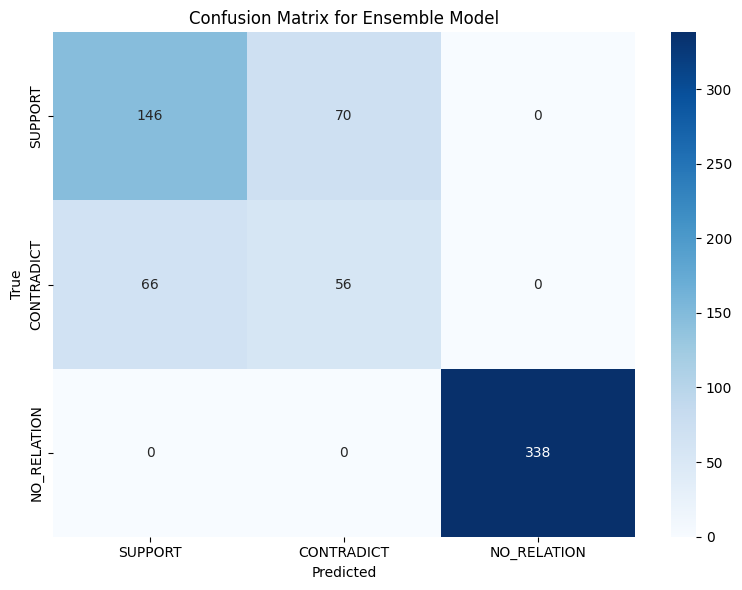

In [19]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["SUPPORT", "CONTRADICT", "NO_RELATION"],
    yticklabels=["SUPPORT", "CONTRADICT", "NO_RELATION"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Ensemble Model")
plt.tight_layout()
plt.show()

### Feature Importance

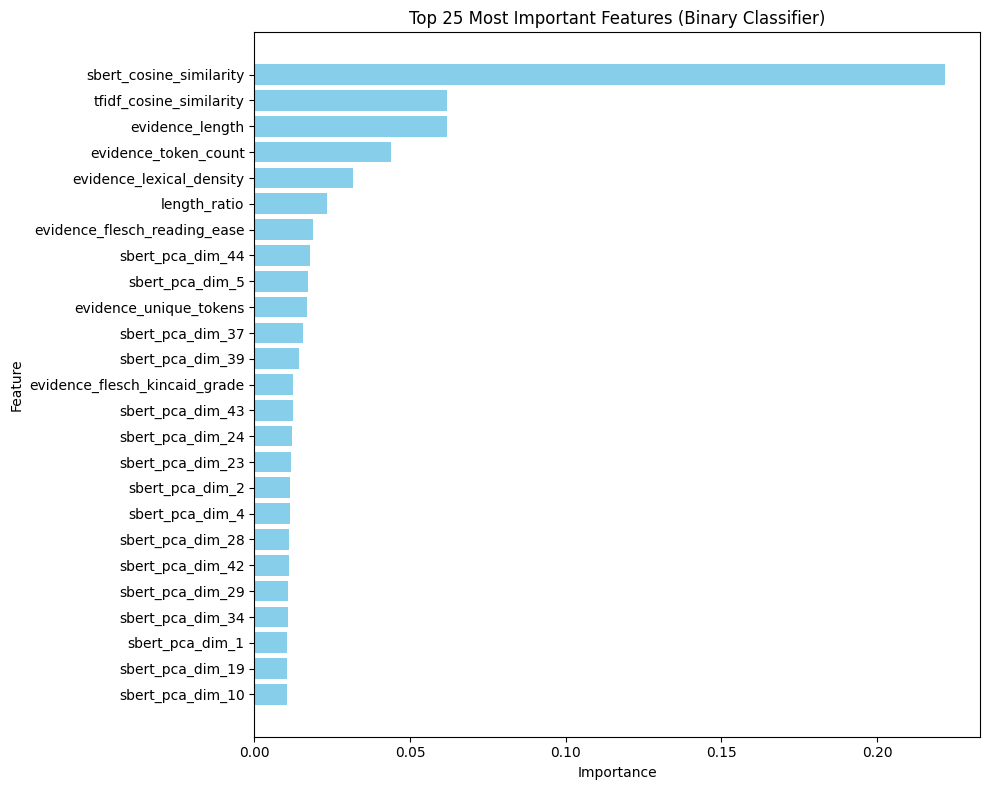

In [20]:
# Extract feature names and importances from the binary classifier
binary_feature_names = binary_train_X.columns.tolist()
binary_feature_importances = binary_pipeline.named_steps[
    "classifier"
].feature_importances_

# Pair feature names with their importance scores
features_with_importance = list(
    zip(binary_feature_names, binary_feature_importances, strict=False)
)

# Sort features by importance in descending order
sorted_features = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

# Select the top 25 features
top_n = 25
top_features = sorted_features[:top_n]

# Unpack feature names and importances for plotting
top_feature_names, top_feature_importances = zip(*top_features, strict=False)

# Plot the top 25 features
plt.figure(figsize=(10, 8))
plt.barh(top_feature_names, top_feature_importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Most Important Features (Binary Classifier)")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.tight_layout()
plt.show()